In [1783]:
import pyforest

1. Understanding & Inspecting the Data


In [1784]:
df = pd.read_csv("Cars_Datasets 2025.csv", encoding="cp1252")
df

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm
...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487 cc,240 hp,180 km/h,7.6 sec,"$43,590 – $48,000",Hybrid (Gas + Electric),5,239 Nm
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393 cc + Battery,326 hp,180 km/h,6.8 sec,"$50,000",Hybrid,7,630 Nm
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987 cc / Hybrid batt,169 – 196 hp,190 km/h,8.0 – 9.2 sec,"$25,210 – $29,135",Gas / Hybrid,5,190 – 210 Nm
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,1798 / 1987 cc + batt,140 – 198 hp,180 km/h,7.9 – 10.5 sec,"€ 33,000",Hybrid,5,190 – 205 Nm


5. Data Type Conversion

In [1785]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


In [1786]:
print("Shape:",df.shape)

Shape: (1218, 11)


In [1787]:
print((df.isnull().sum() / len(df)) * 100)


Company Names                0.000000
Cars Names                   0.000000
Engines                      0.000000
CC/Battery Capacity          0.246305
HorsePower                   0.000000
Total Speed                  0.000000
Performance(0 - 100 )KM/H    0.492611
Cars Prices                  0.000000
Fuel Types                   0.000000
Seats                        0.000000
Torque                       0.082102
dtype: float64


In [1788]:
def extract_car_price(series):
    def parse_price(s):
        if pd.isna(s):
            return np.nan
        s = str(s)
        # Remove any extra spaces
        s = s.replace(' ', '')
        # Regex for ranges with dollar signs (e.g., $1000-$1200 or $1,000 - $1,200)
        match = re.match(r"\$?([\d,]+\.?\d*)\s*-\s*\$?([\d,]+\.?\d*)", s)
        if match:
            prices = [float(p.replace(',', '')) for p in match.groups()]
            # You can change to return min/max, here I'm returning average
            return np.mean(prices)
        # Single price with optional dollar sign and commas
        match = re.search(r"\$?([\d,]+\.?\d*)", s)
        if match:
            return float(match.group(1).replace(',', ''))
        return np.nan

    return series.apply(parse_price)
df["Cars Prices"] = extract_car_price(df["Cars Prices"])

In [1789]:
def extract_numeric(series):

    return pd.to_numeric(
        series.astype(str).str.extract(r'(\d+\.?\d*)')[0],
        errors="coerce"
    )

In [1790]:
df["HorsePower"] = extract_numeric(df["HorsePower"])
df["Torque"] = extract_numeric(df["Torque"])
df["Total Speed"] = extract_numeric(df["Total Speed"])
df["Performance(0 - 100 )KM/H"] = extract_numeric(df["Performance(0 - 100 )KM/H"])

In [1791]:
df["Seats"] = (
    df["Seats"].astype(str)
    .str.replace(r'[^0-9\-]', '', regex=True)   # keep digits and dash
    .apply(lambda x: np.mean([int(i) for i in x.split('-')]) if '-' in x and x.replace('-', '').isdigit() else x)
)
df["Seats"] = pd.to_numeric(df["Seats"], errors="coerce")


In [1792]:
import re

def clean_numeric(value):
    if pd.isna(value):
        return None
    val = re.sub(r'[^0-9.]', '', str(value))
    if val.count('.') > 1:
        first, *rest = val.split('.')
        val = first + '.' + ''.join(rest)
    try:
        return float(val) if val else None
    except:
        return None

df["CC/Battery Capacity"] = df["CC/Battery Capacity"].apply(clean_numeric)


In [1793]:
df["Company Names"] = df["Company Names"].astype("category")
df["Cars Names"]    = df["Cars Names"].astype("category")
df["Engines"]       = df["Engines"].astype("category")
df["Fuel Types"]    = df["Fuel Types"].astype("category")

In [1794]:
df

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990.0,963,340,2.5,1100000.0,plug in hyrbrid,2,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563,250,5.3,460000.0,Petrol,5,900.0
2,Ford,KA+,1.2L Petrol,1200.0,70,165,10.5,13500.0,Petrol,5,100.0
3,MERCEDES,GT 63 S,V8,3982.0,630,250,3.2,161000.0,Petrol,4,900.0
4,AUDI,AUDI R8 Gt,V10,5204.0,602,320,3.6,253290.0,Petrol,2,560.0
...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487.0,240,180,7.6,43590.0,Hybrid (Gas + Electric),5,239.0
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393.0,326,180,6.8,50000.0,Hybrid,7,630.0
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987.0,169,190,8.0,25210.0,Gas / Hybrid,5,190.0
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,17981987.0,140,180,7.9,33000.0,Hybrid,5,190.0


In [1795]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Company Names              1218 non-null   category
 1   Cars Names                 1218 non-null   category
 2   Engines                    1218 non-null   category
 3   CC/Battery Capacity        1213 non-null   float64 
 4   HorsePower                 1218 non-null   int64   
 5   Total Speed                1218 non-null   int64   
 6   Performance(0 - 100 )KM/H  1212 non-null   float64 
 7   Cars Prices                1217 non-null   float64 
 8   Fuel Types                 1218 non-null   category
 9   Seats                      1218 non-null   int64   
 10  Torque                     1217 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 128.5 KB


In [1796]:
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990.0,963,340,2.5,1100000.0,plug in hyrbrid,2,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563,250,5.3,460000.0,Petrol,5,900.0
2,Ford,KA+,1.2L Petrol,1200.0,70,165,10.5,13500.0,Petrol,5,100.0
3,MERCEDES,GT 63 S,V8,3982.0,630,250,3.2,161000.0,Petrol,4,900.0
4,AUDI,AUDI R8 Gt,V10,5204.0,602,320,3.6,253290.0,Petrol,2,560.0


In [1797]:
df.describe(include='all')

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
count,1218,1218,1218,1.213000e+03,1218.000000,1218.000000,1212.000000,1.217000e+03,1218,1218.000000,1217.000000
unique,37,1201,356,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
top,Nissan,Golf Cabriolet,I4,NaN,NaN,NaN,NaN,NaN,Petrol,NaN,NaN
freq,149,2,64,NaN,NaN,NaN,NaN,NaN,871,NaN,NaN
mean,NaN,NaN,NaN,1.573429e+07,300.397373,216.467159,7.563614,1.380237e+05,NaN,5.403120,425.949877
std,NaN,NaN,NaN,1.717775e+08,219.343342,53.051077,3.310014,7.110442e+05,NaN,8.983463,290.616325
min,NaN,NaN,NaN,1.240000e+00,1.000000,80.000000,1.900000,4.000000e+03,NaN,1.000000,1.000000
25%,NaN,NaN,NaN,1.595000e+03,150.000000,180.000000,5.200000,2.800000e+04,NaN,4.000000,250.000000
50%,NaN,NaN,NaN,2.494000e+03,250.000000,200.000000,7.100000,4.250000e+04,NaN,5.000000,366.000000
75%,NaN,NaN,NaN,3.996000e+03,400.000000,250.000000,9.500000,7.000000e+04,NaN,5.000000,560.000000


In [1798]:
df["Cars Prices"].mean()

print(df["Torque"].max())

3500.0


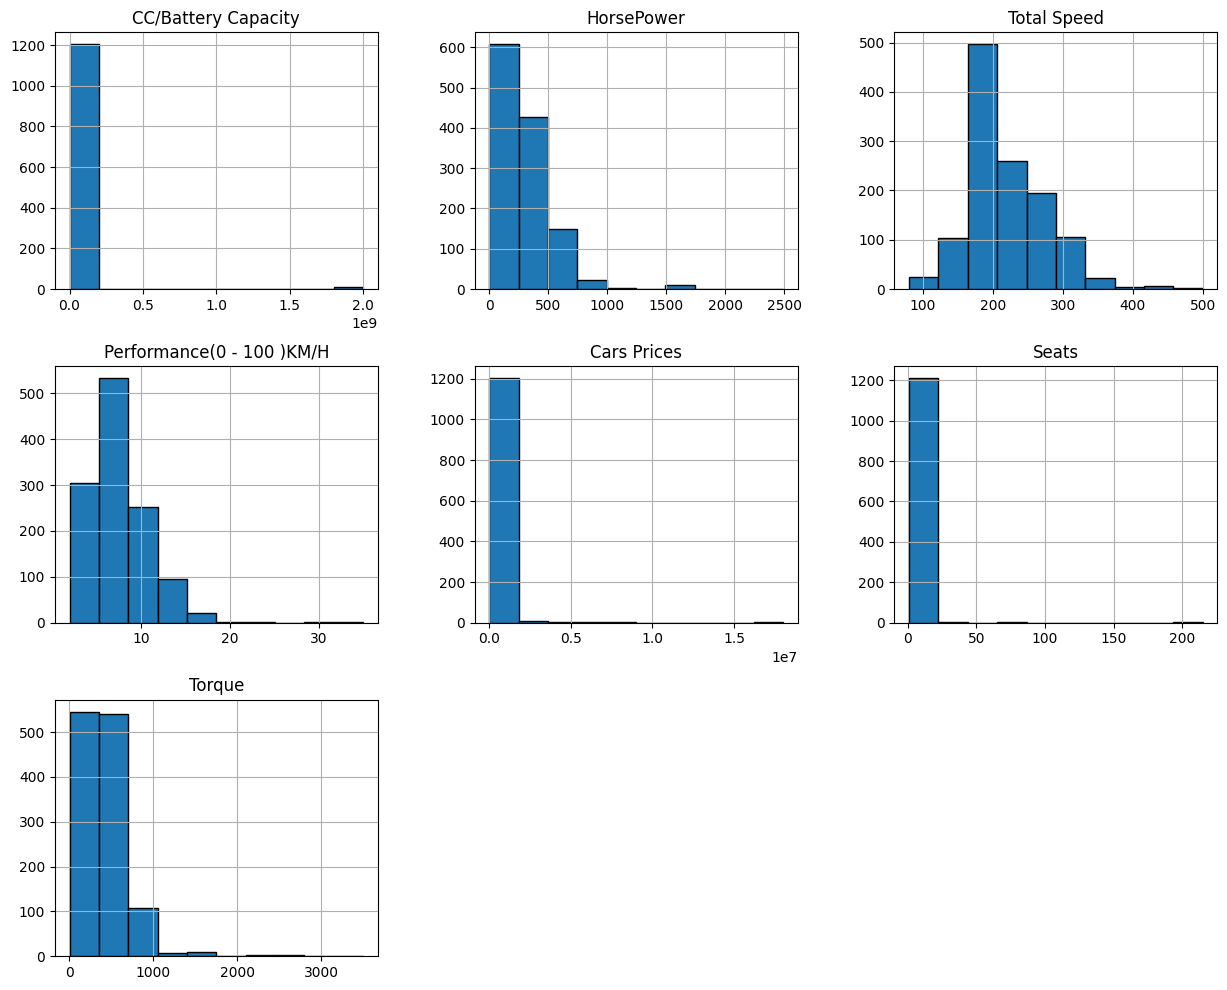

In [1799]:
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

df[numeric_cols].hist(bins=10, figsize=(15, 12), edgecolor='black')
plt.title("Histograms of Numeric Columns", fontsize=10)
plt.show()

<IPython.core.display.Javascript object>

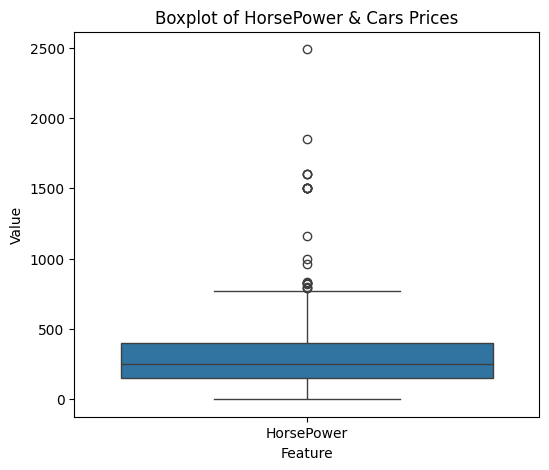

In [1800]:
cols_to_plot = ["HorsePower"]
df_melted = df[cols_to_plot].melt(var_name="Feature", value_name="Value")

plt.figure(figsize=(6, 5))
sns.boxplot(x="Feature", y="Value", data=df_melted)
plt.title("Boxplot of HorsePower & Cars Prices")
plt.show()

<IPython.core.display.Javascript object>

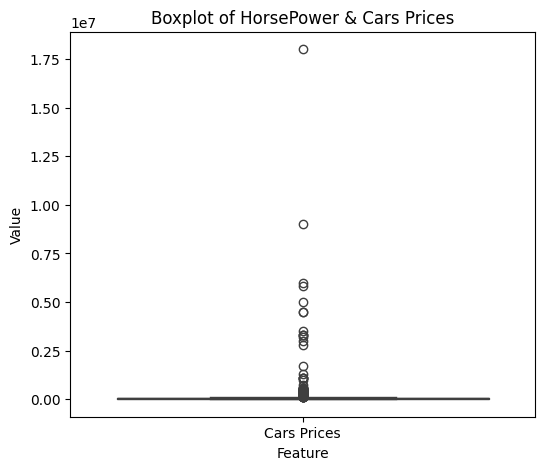

In [1801]:
cols_to_plot = ["Cars Prices"]
df_melted = df[cols_to_plot].melt(var_name="Feature", value_name="Value")

plt.figure(figsize=(6, 5))
sns.boxplot(x="Feature", y="Value", data=df_melted)
plt.title("Boxplot of HorsePower & Cars Prices")
plt.show()

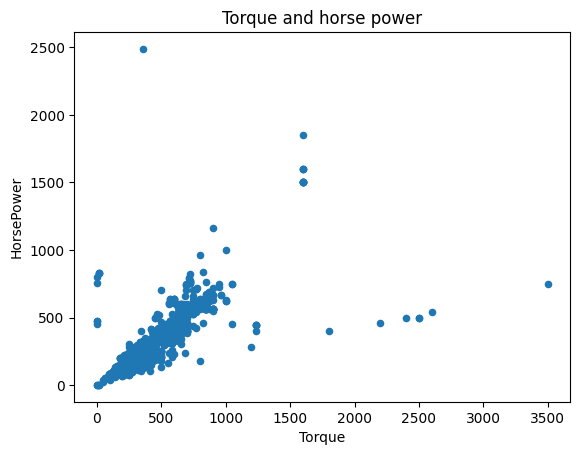

In [1802]:
df.plot(y="HorsePower",x="Torque",kind="scatter")
plt.title("Torque and horse power")
plt.show()

<IPython.core.display.Javascript object>

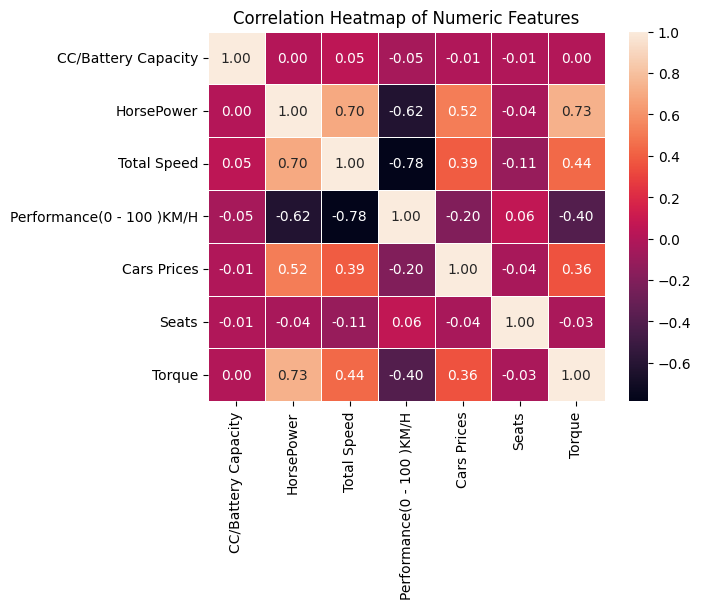

In [1803]:
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [1804]:
corr = df.corr(numeric_only=True)     
corr_unstacked = corr.abs().unstack() 
corr_unstacked = corr_unstacked[corr_unstacked < 1] 
max_corr_pair = corr_unstacked.idxmax()
max_corr_value = corr_unstacked.max()
print("Max correlation is between:", max_corr_pair, "with value:", max_corr_value)


Max correlation is between: ('Total Speed', 'Performance(0 - 100 )KM/H') with value: 0.7847305875151152


2. Handling Missing Data


In [1805]:
print(df.isnull().sum())
print((df.isnull().sum() / len(df)) * 100)


Company Names                0
Cars Names                   0
Engines                      0
CC/Battery Capacity          5
HorsePower                   0
Total Speed                  0
Performance(0 - 100 )KM/H    6
Cars Prices                  1
Fuel Types                   0
Seats                        0
Torque                       1
dtype: int64
Company Names                0.000000
Cars Names                   0.000000
Engines                      0.000000
CC/Battery Capacity          0.410509
HorsePower                   0.000000
Total Speed                  0.000000
Performance(0 - 100 )KM/H    0.492611
Cars Prices                  0.082102
Fuel Types                   0.000000
Seats                        0.000000
Torque                       0.082102
dtype: float64


In [1806]:
df = df.dropna(subset=["CC/Battery Capacity"])  

df["HorsePower"].fillna(df["HorsePower"].mean(), inplace=True)

df["Cars Prices"].fillna(df["Cars Prices"].median(), inplace=True)


C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\4114925385.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["HorsePower"].fillna(df["HorsePower"].mean(), inplace=True)
C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\4114925385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HorsePower"].fillna(df["HorsePower"].mean(), inp

In [1807]:
for col in df.select_dtypes(include="category").columns:
    df[col] = df[col].astype(str).replace("nan", "Unknown")


C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\2517029092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).replace("nan", "Unknown")
C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\2517029092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).replace("nan", "Unknown")
C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\2517029092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [1808]:
df["Torque"] = df["Torque"].interpolate(method="linear")
df["Performance(0 - 100 )KM/H"] = df["Performance(0 - 100 )KM/H"].interpolate(method='linear')

C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\5959942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Torque"] = df["Torque"].interpolate(method="linear")
C:\Users\ASM9017\AppData\Local\Temp\ipykernel_22020\5959942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Performance(0 - 100 )KM/H"] = df["Performance(0 - 100 )KM/H"].interpolate(method='linear')


3. Handling Duplicates

In [1809]:
df = df.drop_duplicates()
df.count()

Company Names                1208
Cars Names                   1208
Engines                      1208
CC/Battery Capacity          1208
HorsePower                   1208
Total Speed                  1208
Performance(0 - 100 )KM/H    1208
Cars Prices                  1208
Fuel Types                   1208
Seats                        1208
Torque                       1208
dtype: int64

In [1810]:
d1=df.groupby(["Company Names"])["Cars Prices"].mean()
d2=d1.astype(int)
d2 = d2.sort_values(ascending=True)  
d2   

Company Names
MARUTI SUZUKI          12066
Tata Motors            12507
MAHINDRA               18400
KIA                    26500
Mitsubishi             28850
HONDA                  29364
HYUNDAI                31495
KIA                    34093
Peugeot                35144
Toyota                 36160
Volkswagen             36437
Kia                    36759
NISSAN                 39600
TOYOTA                 42865
Chevrolet              44627
Jeep                   51439
Ford                   54211
VOLVO                  58333
Nissan                 60729
Cadillac               62178
Acura                  63259
GMC                    63293
BMW                    67317
Jaguar Land Rover      72000
AUDI                   82870
MERCEDES               83300
Tesla                  87032
Mazda                  93825
Volvo                 110000
Porsche               138389
BENTLEY               311000
ROLLS ROYCE           332000
ROLLS ROYCE           392413
FERRARI               512222


In [1811]:
max_row = df.nlargest(5,"Cars Prices")
max_row

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
887,Bugatti,La Voiture Noire,8.0L Quad-Turbo W16,7993.0,1500,420,2.5,18000000.0,Petrol,2,1600.0
886,Bugatti,Centodieci,8.0L Quad-Turbo W16,7993.0,1600,380,2.4,9000000.0,Petrol,2,1600.0
1212,Mazda,787B (Race Car),2.6L Wankel Rotary Engine,2620.0,700,320,3.5,6000000.0,Petrol,1,500.0
885,Bugatti,Divo,8.0L Quad-Turbo W16,7993.0,1500,380,2.4,5800000.0,Petrol,2,1600.0
889,Bugatti,Mistral,8.0L Quad-Turbo W16,7993.0,1600,420,2.4,5000000.0,Petrol,2,1600.0


4. Outlier Detection & Treatment


In [1812]:
from scipy.stats import zscore
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
z_scores = df[num_cols].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print("Total outliers detected:", outliers.sum())
df[outliers].sort_values(by="Cars Prices",ascending=False).head(4)

Total outliers detected: 45


,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
887,Bugatti,La Voiture Noire,8.0L Quad-Turbo W16,7993.0,1500,420,2.5,18000000.0,Petrol,2,1600.0
886,Bugatti,Centodieci,8.0L Quad-Turbo W16,7993.0,1600,380,2.4,9000000.0,Petrol,2,1600.0
1212,Mazda,787B (Race Car),2.6L Wankel Rotary Engine,2620.0,700,320,3.5,6000000.0,Petrol,1,500.0
885,Bugatti,Divo,8.0L Quad-Turbo W16,7993.0,1500,380,2.4,5800000.0,Petrol,2,1600.0


In [1813]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print("Total outliers detected:", outliers.sum())
df[outliers].head()

Total outliers detected: 498


,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990.0,963,340,2.5,1100000.0,plug in hyrbrid,2,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563,250,5.3,460000.0,Petrol,5,900.0
3,MERCEDES,GT 63 S,V8,3982.0,630,250,3.2,161000.0,Petrol,4,900.0
4,AUDI,AUDI R8 Gt,V10,5204.0,602,320,3.6,253290.0,Petrol,2,560.0
5,BMW,Mclaren 720s,V8,3994.0,710,341,2.9,499000.0,Petrol,2,770.0


In [1814]:
#winsorisation
for col in num_cols:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    df[col] = np.clip(df[col], lower, upper)

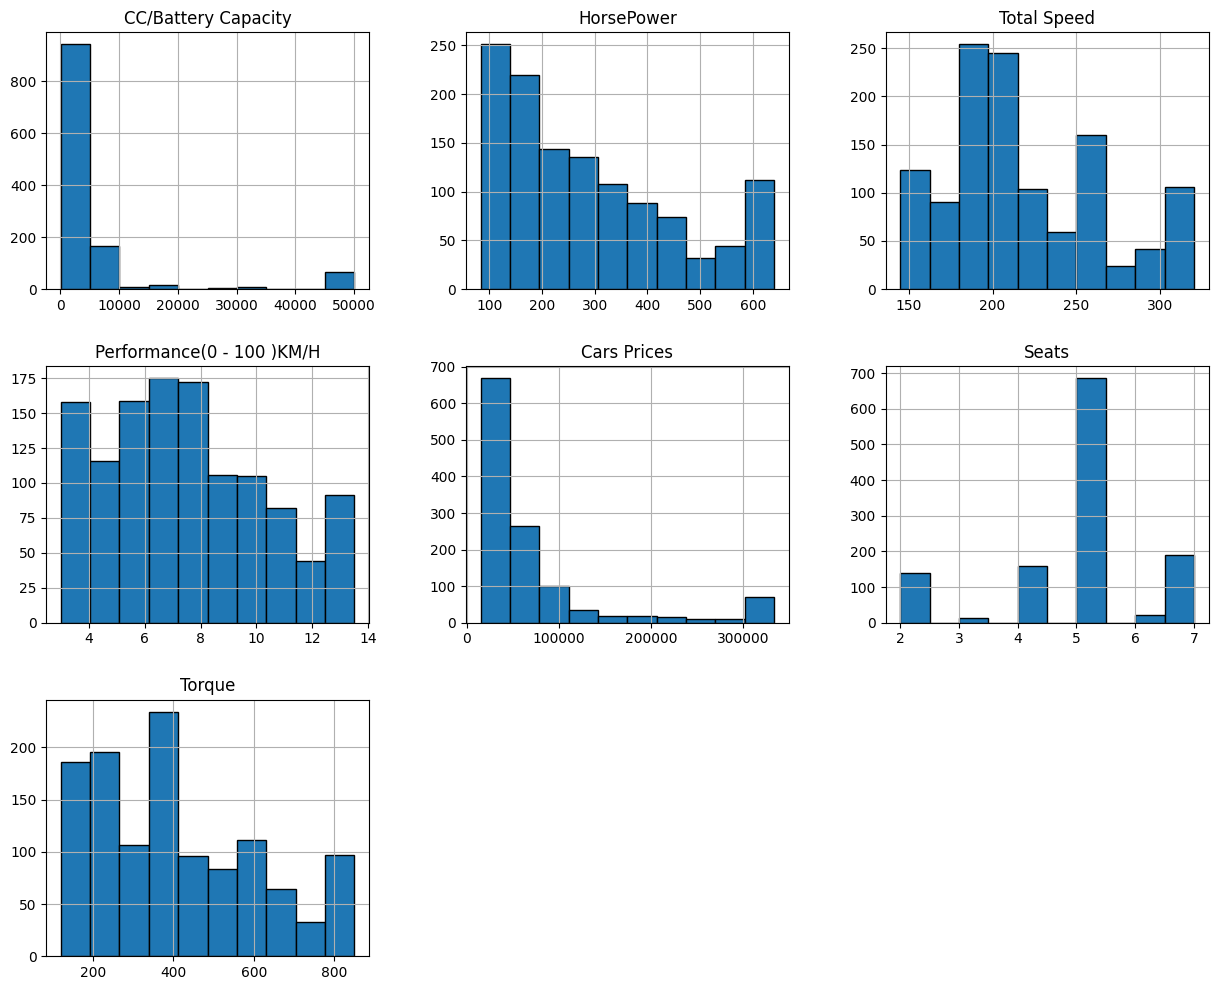

In [1815]:
df.hist(figsize=(15,12),edgecolor="black")
plt.show()

6. Encoding Categorical Variables



In [1816]:
# 1. Frequency encoding for Company Names
#df["Company_Name_FreqEnc"] = df["Company Names"].map(df["Company Names"].value_counts())
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990.0,640.0,320,3.0,333950.0,plug in hyrbrid,2,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563.0,250,5.3,333950.0,Petrol,5,850.0
2,Ford,KA+,1.2L Petrol,1200.0,83.7,165,10.5,15000.0,Petrol,5,120.0
3,MERCEDES,GT 63 S,V8,3982.0,630.0,250,3.2,161000.0,Petrol,4,850.0
4,AUDI,AUDI R8 Gt,V10,5204.0,602.0,320,3.6,253290.0,Petrol,2,560.0


In [1817]:
# 2. One-hot encode Engines & Fuel Types
df_1 = pd.get_dummies(df, columns=["Engines", "Fuel Types"], drop_first=True)
df_1.head()


,Company Names,Cars Names,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Seats,Torque,Engines_0.66L Inline-3,...,Fuel Types_Hydrogen,Fuel Types_Petrol,"Fuel Types_Petrol, Diesel","Fuel Types_Petrol, Hybrid",Fuel Types_Petrol/AWD,Fuel Types_Petrol/Diesel,Fuel Types_Petrol/EV,Fuel Types_Petrol/Hybrid,Fuel Types_Plug-in Hybrid,Fuel Types_plug in hyrbrid
0,FERRARI,SF90 STRADALE,3990.0,640.0,320,3.0,333950.0,2,800.0,False,...,False,False,False,False,False,False,False,False,False,True
1,ROLLS ROYCE,PHANTOM,6749.0,563.0,250,5.3,333950.0,5,850.0,False,...,False,True,False,False,False,False,False,False,False,False
2,Ford,KA+,1200.0,83.7,165,10.5,15000.0,5,120.0,False,...,False,True,False,False,False,False,False,False,False,False
3,MERCEDES,GT 63 S,3982.0,630.0,250,3.2,161000.0,4,850.0,False,...,False,True,False,False,False,False,False,False,False,False
4,AUDI,AUDI R8 Gt,5204.0,602.0,320,3.6,253290.0,2,560.0,False,...,False,True,False,False,False,False,False,False,False,False



 7. Feature Scaling

In [1818]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [1819]:
numeric_cols = ["CC/Battery Capacity", "HorsePower", "Total Speed", 
                "Performance(0 - 100 )KM/H", "Cars Prices", "Seats", "Torque"]

X = df[numeric_cols].copy()

In [1820]:
scaler = StandardScaler()
X_1 = scaler.fit_transform(X)
X_1 = pd.DataFrame(X_1, columns=numeric_cols)
X_1.head()

,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Seats,Torque
0,-0.165846,2.128732,2.221591,-1.548247,3.287480,-2.097099,1.878964
1,0.079496,1.662990,0.725420,-0.747881,3.287480,0.123791,2.119237
2,-0.413945,-1.236103,-1.091359,1.061644,-0.712683,0.123791,-1.388744
3,-0.166558,2.068246,0.725420,-1.478650,1.118400,-0.616505,2.119237
4,-0.057892,1.898886,2.221591,-1.339456,2.275869,-2.097099,0.725655


In [1821]:
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X)
X_mm = pd.DataFrame(X_mm, columns=numeric_cols)
X_mm.head()

,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Seats,Torque
0,0.078244,1.000000,1.000000,0.000000,1.000000,0.0,0.931507
1,0.133507,0.861585,0.600000,0.219048,1.000000,0.6,1.000000
2,0.022359,0.000000,0.114286,0.714286,0.000000,0.6,0.000000
3,0.078083,0.982024,0.600000,0.019048,0.457752,0.4,1.000000
4,0.102560,0.931692,1.000000,0.057143,0.747108,0.0,0.602740


In [1822]:
scaler_mm = RobustScaler()
X_r = scaler_mm.fit_transform(X)
X_r = pd.DataFrame(X_r, columns=numeric_cols)
X_r.head()

,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Seats,Torque
0,0.623593,1.5600,1.714286,-0.953488,6.931964,-3.0,1.400000
1,1.773656,1.2520,0.714286,-0.418605,6.931964,0.0,1.561290
2,-0.539391,-0.6652,-0.500000,0.790698,-0.662083,0.0,-0.793548
3,0.620258,1.5200,0.714286,-0.906977,2.814107,-1.0,1.561290
4,1.129637,1.4080,1.714286,-0.813953,5.011488,-3.0,0.625806


8. Feature Engineering & Transformation

In [1823]:
df["Cars Prices"] = np.ceil(np.sqrt(df["Cars Prices"]))
df["HorsePower"] = np.ceil(np.sqrt(df["HorsePower"]))
df["CC/Battery Capacity"] = np.ceil(np.sqrt(df["CC/Battery Capacity"]))

df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,64.0,26.0,320,3.0,578.0,plug in hyrbrid,2,800.0
1,ROLLS ROYCE,PHANTOM,V12,83.0,24.0,250,5.3,578.0,Petrol,5,850.0
2,Ford,KA+,1.2L Petrol,35.0,10.0,165,10.5,123.0,Petrol,5,120.0
3,MERCEDES,GT 63 S,V8,64.0,26.0,250,3.2,402.0,Petrol,4,850.0
4,AUDI,AUDI R8 Gt,V10,73.0,25.0,320,3.6,504.0,Petrol,2,560.0


In [1824]:
# # Combine rare company names
# company_counts = df["Company Names"].value_counts()
# rare_companies = company_counts[company_counts < 5].index  # threshold = <5 occurrences
# df["Company Names"] = df["Company Names"].replace(rare_companies, "Other")
# df.head()



In [1825]:
import numpy as np

# Normalize strings
df["Fuel Types"] = df["Fuel Types"].str.strip().str.lower()

def clean_fuel(x):
    if pd.isna(x):
        return "Other"
    elif "petrol" in x and "diesel" not in x and "hybrid" not in x and "ev" not in x:
        return "Petrol"
    elif "diesel" in x and "hybrid" not in x:
        return "Diesel"
    elif ("electric" in x) or ("hybrid" in x) or ("ev" in x) or ("plug" in x):
        return "Electric/Hybrid"
    else:
        return "Other"

df["Fuel Types"] = df["Fuel Types"].apply(clean_fuel)

print(df["Fuel Types"].unique())
print(df["Fuel Types"].value_counts())


['Electric/Hybrid' 'Petrol' 'Diesel' 'Other']
Fuel Types
Petrol             871
Electric/Hybrid    206
Diesel             128
Other                3
Name: count, dtype: int64


9. Handling Class Imbalance (Classification Only)


              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.94      0.41      0.58        41
           2       0.00      0.00      0.00         1
           3       0.86      0.99      0.92       174

    accuracy                           0.86       242
   macro avg       0.67      0.53      0.57       242
weighted avg       0.87      0.86      0.84       242



c:\Users\ASM9017\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ASM9017\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASM9017\AppDa

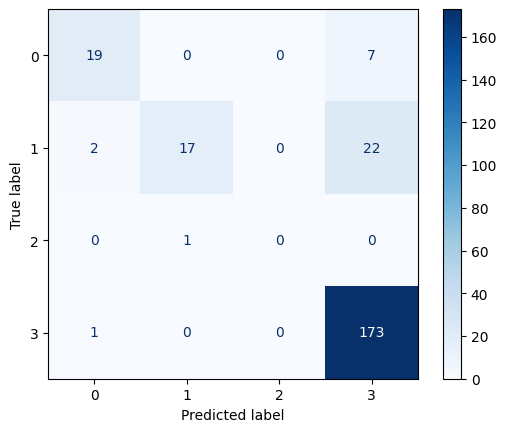

In [1826]:

# Copy original df
df_n = df.copy()

# Encode all categorical/object columns
for col in df_n.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df_n[col] = le.fit_transform(df_n[col])

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = df_n.drop("Fuel Types", axis=1)
y = df_n["Fuel Types"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap="Blues")


In [1827]:
df_n.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,8,885,351,64.0,26.0,320,3.0,578.0,1,2,800.0
1,28,739,343,83.0,24.0,250,5.3,578.0,3,5,850.0
2,9,609,26,35.0,10.0,165,10.5,123.0,3,5,120.0
3,21,0,351,64.0,26.0,250,3.2,402.0,3,4,850.0
4,1,139,342,73.0,25.0,320,3.6,504.0,3,2,560.0


In [1828]:
import pandas as pd

# Example: new car data as a dictionary aligned with feature columns
new_car_data = {
    'Company Names': 10,
    'Cars Names': 10,
    'Engines': 8,
    'CC/Battery Capacity': 3982.0,
    'HorsePower': 25.099801,
    'Total Speed': 250,
    'Performance(0 - 100 )KM/H': 11.989166,
    'Cars Prices': 12.718750,
    'Seats': 4,
    'Torque': 850.0,
    # add all other features your model expects
}

df_new = pd.DataFrame([new_car_data])


In [1829]:
y_pred = log_reg.predict(df_new)
fuel_type_pred = le.inverse_transform(y_pred)
print(fuel_type_pred[0])


Diesel
